# Ring strain workflow (All sizes): generate & visualize structures
This notebook uses **`ring_strain_graph_fix.py`** to build and visualize:
- **M** (macrocycle)
- **M_open** (cut bond + cap ends)
- **X** (local reference fragment around the cut)
- **X_open** (same cut inside X + caps)

It supports **small / medium / large** demos and saves outputs (XYZ + a manifest JSON) so a second notebook
can load them and run **DFT + PCM (COSMO-like)** energies to compute:
\[E_{\mathrm{strain}}(b) = (E(M_{\mathrm{open}})-E(M)) - (E(X_{\mathrm{open}})-E(X)).\]

## Outputs
All outputs go under `ring_strain_outputs_all_sizes/` with a top-level `manifest.json`.


In [1]:
import rdkit
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
print('RDKit', rdkit.__version__)
print('NetworkX', nx.__version__)


RDKit 2025.09.3
NetworkX 3.6.1


In [2]:
import ring_strain_graph_fix as rs
from pathlib import Path
import json
print('Loaded:', rs.__file__)


Loaded: /home/thomas-watts/Desktop/pyLIQTR/ring_strain/ring_strain_graph_fix.py


## 1) Choose a demo size (small / medium / large)

In [6]:
DEMO = 'large'  # 'small' | 'medium' | 'large'

# Small: cyclooctane (C8 ring)
SMI_SMALL = 'C1CCCCCCC1'

# Medium: cyclododecane (C12 ring)
SMI_MEDIUM = 'C1CCCCCCCCCCC1'

# Large: cyclic peptide from 1-letter sequence (head-to-tail)
SEQ_LARGE = 'ALK'  # Ala-Cys-Asp-Pro-Phe-Trp-Lys


## 2) Build large cyclic peptide SMILES (if DEMO='large')

In [7]:
def cyclize_peptide_from_sequence(seq: str) -> Chem.Mol:
    """Head-to-tail cyclization:
      - remove C-terminal OH (and its H)
      - remove one N-terminal H
      - add N—C bond
    """
    m = Chem.MolFromSequence(seq)
    if m is None:
        raise ValueError('MolFromSequence failed. Provide a cyclic SMILES instead.')
    m = Chem.AddHs(m)
    rw = Chem.RWMol(m)

    # N-terminus
    n_idx = None
    for a in rw.GetAtoms():
        if a.GetSymbol() != 'N':
            continue
        heavy = [n for n in a.GetNeighbors() if n.GetAtomicNum() > 1]
        hs = [n for n in a.GetNeighbors() if n.GetAtomicNum() == 1]
        if len(heavy) == 1 and len(hs) >= 1:
            n_idx = a.GetIdx()
            break
    if n_idx is None:
        raise RuntimeError('Could not find N-terminus N')

    # C-terminus carbonyl C + hydroxyl O(H)
    c_idx = None
    oh_idx = None
    for a in rw.GetAtoms():
        if a.GetSymbol() != 'C':
            continue
        o_nbrs = []
        for b in a.GetBonds():
            n = b.GetOtherAtom(a)
            if n.GetSymbol() == 'O':
                o_nbrs.append((n.GetIdx(), b.GetBondType()))
        if len(o_nbrs) < 2:
            continue
        has_dbo = any(bt == Chem.BondType.DOUBLE for _, bt in o_nbrs)
        if not has_dbo:
            continue
        for oi, bt in o_nbrs:
            if bt != Chem.BondType.SINGLE:
                continue
            oatom = rw.GetAtomWithIdx(oi)
            if any(n.GetAtomicNum() == 1 for n in oatom.GetNeighbors()):
                c_idx = a.GetIdx(); oh_idx = oi
                break
        if c_idx is not None:
            break
    if c_idx is None or oh_idx is None:
        raise RuntimeError('Could not find C-terminus carbonyl C / hydroxyl O')

    # Remove hydroxyl H then O
    oh_atom = rw.GetAtomWithIdx(oh_idx)
    h_on_oh = [n.GetIdx() for n in oh_atom.GetNeighbors() if n.GetAtomicNum() == 1]
    for hi in sorted(h_on_oh, reverse=True):
        rw.RemoveAtom(hi)
        if hi < oh_idx: oh_idx -= 1
        if hi < c_idx: c_idx -= 1
        if hi < n_idx: n_idx -= 1
    rw.RemoveAtom(oh_idx)
    if oh_idx < c_idx: c_idx -= 1
    if oh_idx < n_idx: n_idx -= 1

    # Remove one N-terminal H
    n_atom = rw.GetAtomWithIdx(n_idx)
    n_h = [n.GetIdx() for n in n_atom.GetNeighbors() if n.GetAtomicNum() == 1]
    h_remove = max(n_h)
    rw.RemoveAtom(h_remove)
    if h_remove < c_idx: c_idx -= 1
    if h_remove < n_idx: n_idx -= 1

    # Add new bond N—C
    rw.AddBond(n_idx, c_idx, Chem.BondType.SINGLE)

    mcyc = rw.GetMol()
    Chem.SanitizeMol(mcyc)
    return Chem.RemoveHs(mcyc)

def get_demo_smiles(demo: str) -> tuple[str, str]:
    if demo == 'small':
        return 'small_cyclooctane', SMI_SMALL
    if demo == 'medium':
        return 'medium_cyclododecane', SMI_MEDIUM
    if demo == 'large':
        m = cyclize_peptide_from_sequence(SEQ_LARGE)
        return f'large_cyclic_peptide_{SEQ_LARGE}', Chem.MolToSmiles(m)
    raise ValueError('DEMO must be small|medium|large')

ring_name, smi = get_demo_smiles(DEMO)
print('Demo:', DEMO)
print('Ring name:', ring_name)
print('SMILES:', smi)
print('Heavy atoms:', Chem.MolFromSmiles(smi).GetNumAtoms())


Demo: large
Ring name: large_cyclic_peptide_ALK
SMILES: CC(C)C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC1=O
Heavy atoms: 22


## 3) Choose bonds to cut and visualize M/M_open/X/X_open

Candidate cut bonds: 9
First 30: [4, 5, 7, 9, 10, 12, 18, 19, 21]
bonds_to_try: [4, 10, 21]
ref_radius: 3

=== bond 4 ===
  M      formula = C15H28N4O3
  M_open formula = C15H30N4O3
  X      formula = C10H21N3O2
  X_open formula = C10H23N3O2


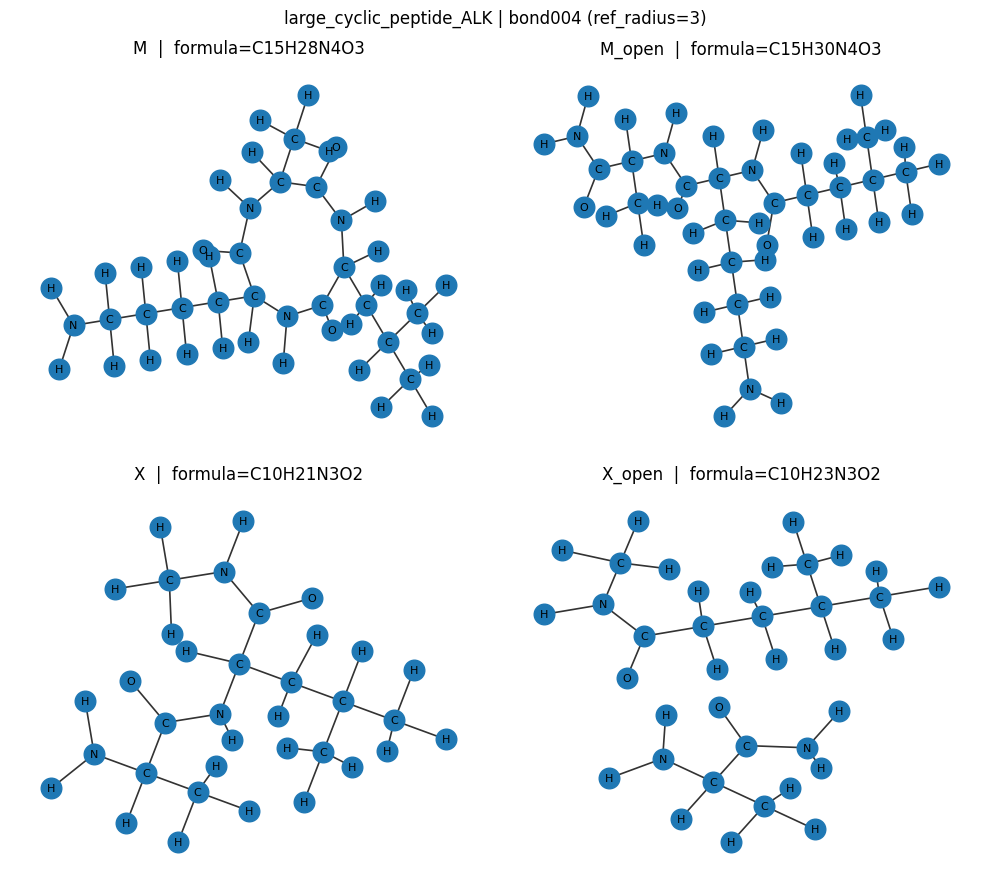


=== bond 10 ===
  M      formula = C15H28N4O3
  M_open formula = C15H30N4O3
  X      formula = C8H17N3O2
  X_open formula = C8H19N3O2


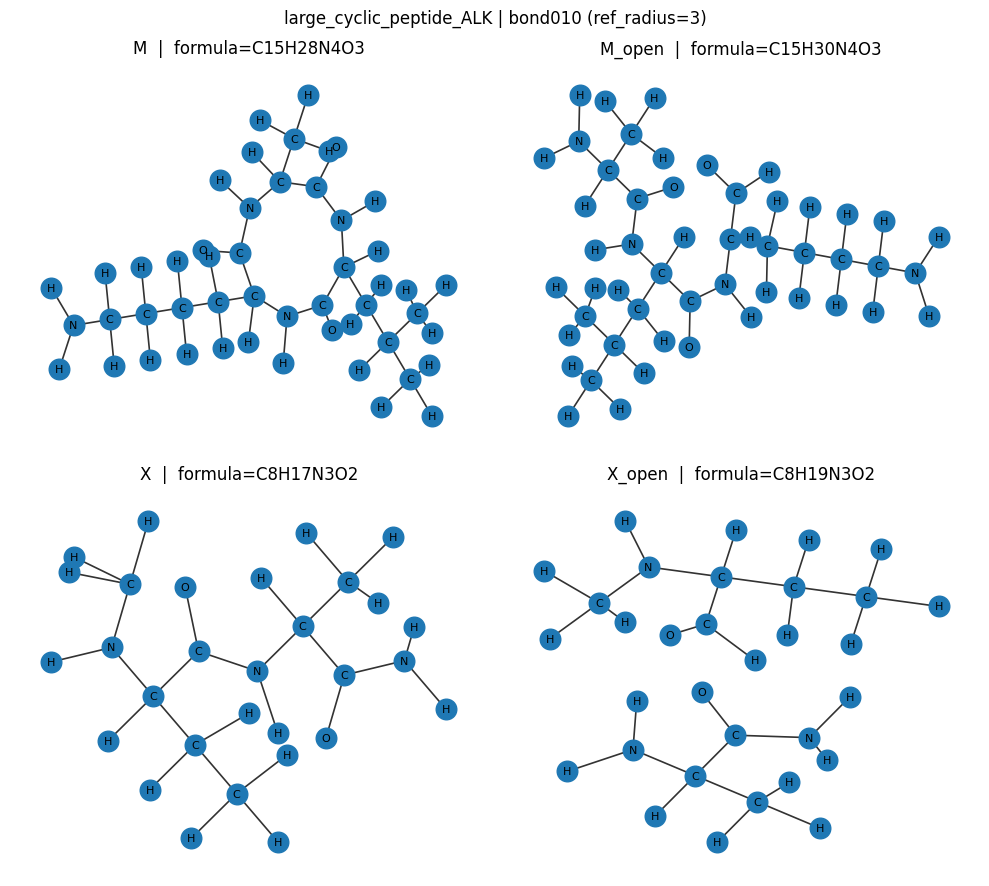


=== bond 21 ===
  M      formula = C15H28N4O3
  M_open formula = C15H30N4O3
  X      formula = C11H22N2O2
  X_open formula = C11H24N2O2


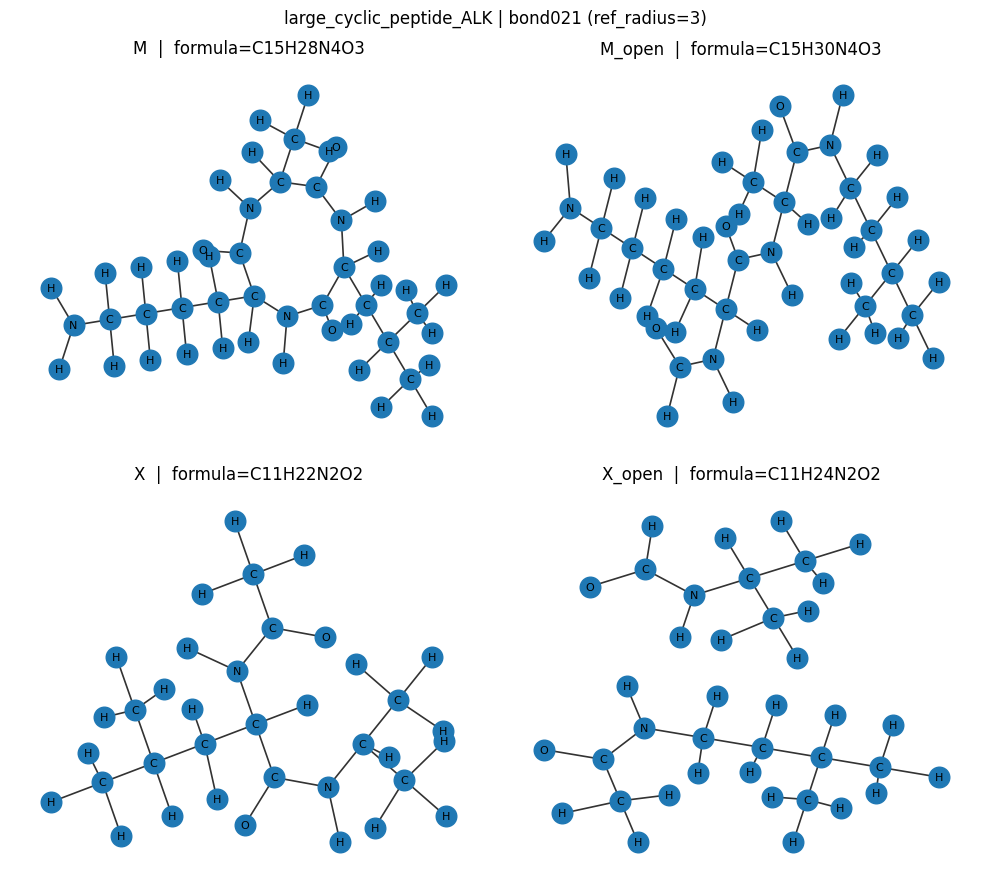

In [8]:
M_heavy = Chem.MolFromSmiles(smi)

# Candidate ring bonds
cand = rs.list_candidate_cut_bonds(M_heavy, allow_aromatic=False, allow_multiple=False, avoid_shared_ring_bonds=True)

# Extra filter for peptides: avoid cutting aromatic rings (Phe/Trp) by requiring non-aromatic atoms
cand2 = []
for bi in cand:
    b = M_heavy.GetBondWithIdx(bi)
    if (not b.GetBeginAtom().GetIsAromatic()) and (not b.GetEndAtom().GetIsAromatic()):
        cand2.append(bi)
cand_use = cand2 if len(cand2) else cand

print('Candidate cut bonds:', len(cand_use))
print('First 30:', cand_use[:30])

# Choose a subset to demo
bonds_to_try = rs.choose_subset_bonds_evenly(cand_use, k=3)
print('bonds_to_try:', bonds_to_try)

# X neighborhood size
ref_radius = 2 if DEMO in ['small','medium'] else 3
print('ref_radius:', ref_radius)

for b in bonds_to_try:
    sp = rs.build_structures(smi, bond_idx=b, ref_radius=ref_radius, cap='H')
    print('\n=== bond', b, '===')
    for name in ['M','M_open','X','X_open']:
        print(f"  {name:6s} formula = {rs.mol_formula(sp[name])}")
    rs.plot_species_grid(sp, title=f"{ring_name} | bond{b:03d} (ref_radius={ref_radius})")


## 4) Generate ETKDG conformers, MMFF-rank, save top-m XYZ + manifest

In [9]:
from pathlib import Path

out_root = Path('ring_strain_outputs_all_sizes')
out_root.mkdir(exist_ok=True)

num_confs = 60 if DEMO in ['small','medium'] else 40
top_m = 3
window = 5.0 if DEMO in ['small','medium'] else 8.0

manifest = []
for b in bonds_to_try:
    sp = rs.build_structures(smi, bond_idx=b, ref_radius=ref_radius, cap='H')
    bond_tag = f"bond{b:03d}"
    out_dir = out_root / ring_name / bond_tag
    out_dir.mkdir(parents=True, exist_ok=True)

    entry = {
        'ring': ring_name,
        'demo': DEMO,
        'smiles': smi,
        'bond_idx': int(b),
        'bond_tag': bond_tag,
        'ref_radius': int(ref_radius),
        'species': {}
    }

    for name in ['M','M_open','X','X_open']:
        mol3d, ranked = rs.embed_mmff_rank(sp[name], num_confs=num_confs, seed=0xC0FFEE + 31*b + (7 if name=='X_open' else 0))
        keep = rs.choose_top_m(ranked, top_m=top_m, window=window)
        xyz_path = out_dir / f"{name}_top{len(keep)}.xyz"
        rs.write_xyz_multiframe(mol3d, keep, str(xyz_path), comment_prefix=f"{name} MMFF-ranked")

        entry['species'][name] = {
            'xyz': str(xyz_path),
            'n_confs': int(len(keep)),
            'mmff_e0': float(ranked[0].mmff_energy),
            'formula': rs.mol_formula(sp[name])
        }
        print('wrote', xyz_path)

    manifest.append(entry)

manifest_path = out_root / 'manifest.json'
manifest_path.write_text(json.dumps(manifest, indent=2))
print('\nWrote manifest:', manifest_path.resolve())
print('Entries:', len(manifest))


wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond004/M_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond004/M_open_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond004/X_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond004/X_open_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond010/M_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond010/M_open_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond010/X_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond010/X_open_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond021/M_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond021/M_open_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond021/X_top3.xyz
wrote ring_strain_outputs_all_sizes/large_cyclic_peptide_ALK/bond021/X_open_top3.xyz

Wrote man

## Next notebook
Open `ring_strain_dft_pcm_all_sizes.ipynb` to load `manifest.json`, run PySCF DFT+PCM energies,
and compute **E_strain(b)** for each saved bond choice.